<ipython-input-2-d754b5007635>:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['wd'] = df['wd'].fillna(method='ffill').fillna(method='bfill')


--- Data Loaded and Preprocessed ---
Shape of processed DataFrame: (35064, 36)
                     PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  DEWP  \
datetime                                                                        
2013-03-01 00:00:00    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0 -18.8   
2013-03-01 01:00:00    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2 -18.2   
2013-03-01 02:00:00    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5 -18.2   
2013-03-01 03:00:00    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5 -19.4   
2013-03-01 04:00:00    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2 -19.5   

                     RAIN  ...  wd_SSE  wd_SSW  wd_SW   wd_W  wd_WNW  wd_WSW  \
datetime                   ...                                                 
2013-03-01 00:00:00   0.0  ...   False   False  False  False   False   False   
2013-03-01 01:00:00   0.0  ...   False   False  False  False   False   False   
2013-03-01 02:00:00   0.0  ...   

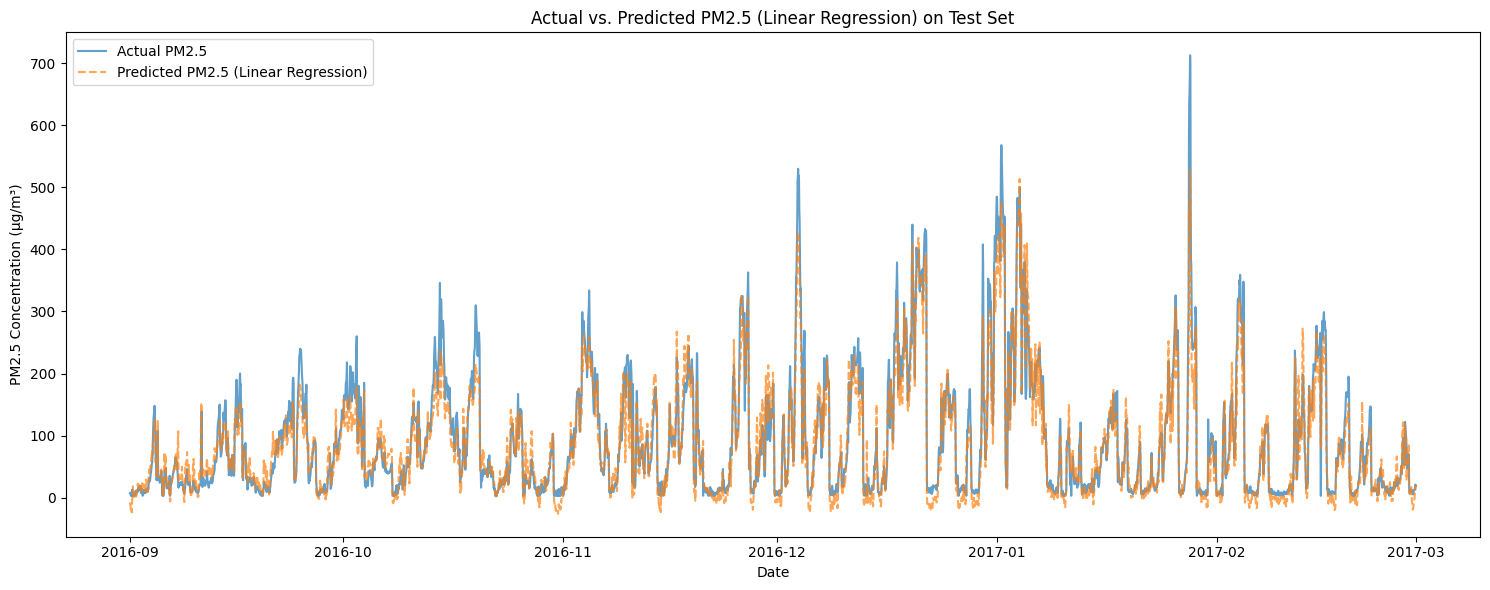


--- Training Random Forest Regressor Model (Initial) ---
Validation Set Evaluation (Random Forest - Initial):
--- Random Forest Initial (Validation) Model Evaluation ---
Mean Squared Error (MSE): 642.8314
Root Mean Squared Error (RMSE): 25.3541
Mean Absolute Error (MAE): 12.6381
R-squared (R²): 0.8565

Test Set Evaluation (Random Forest - Initial):
--- Random Forest Initial (Test) Model Evaluation ---
Mean Squared Error (MSE): 742.3170
Root Mean Squared Error (RMSE): 27.2455
Mean Absolute Error (MAE): 16.1638
R-squared (R²): 0.9244


--- Hyperparameter Tuning for Random Forest ---
Starting GridSearchCV for Random Forest... (This may take some time)
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}

Validation Set Evaluation (Random Forest - Tuned):
--- Random Forest Tuned (Validation) Model Evaluation ---
Mean Squared Error (MSE): 636.7557
Root Mean Square

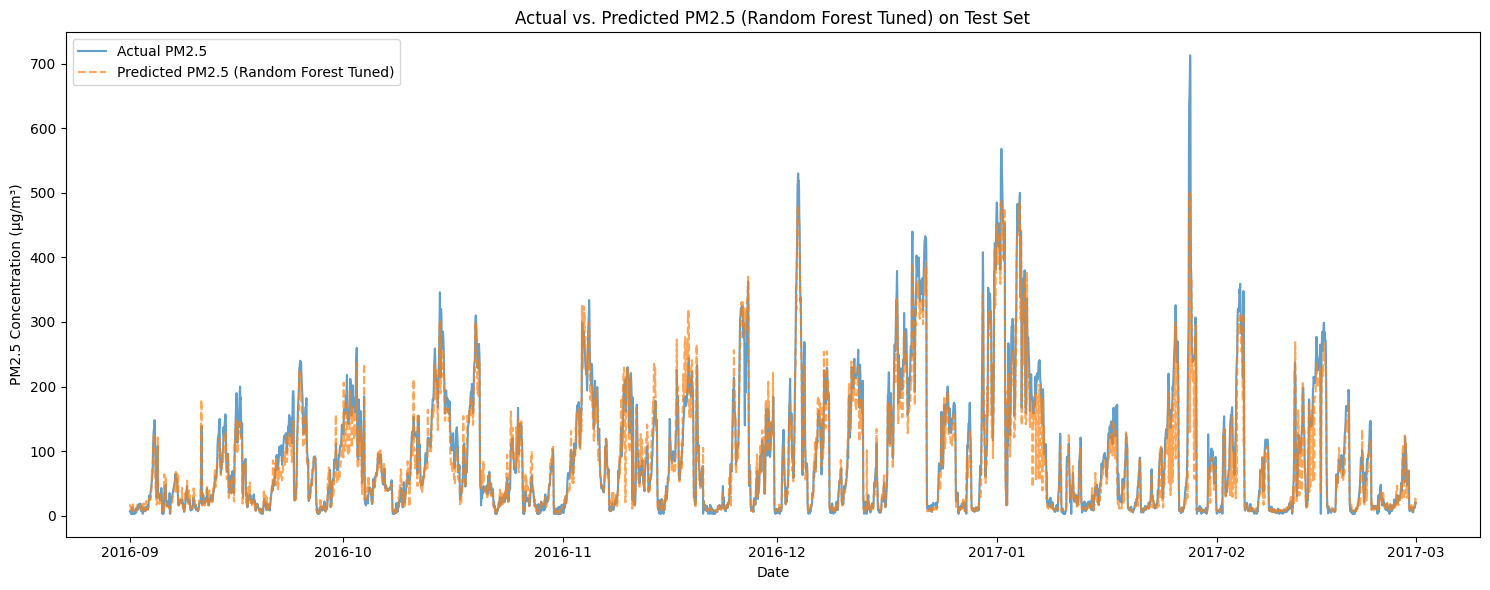


--- Feature Importances (Tuned Random Forest) ---


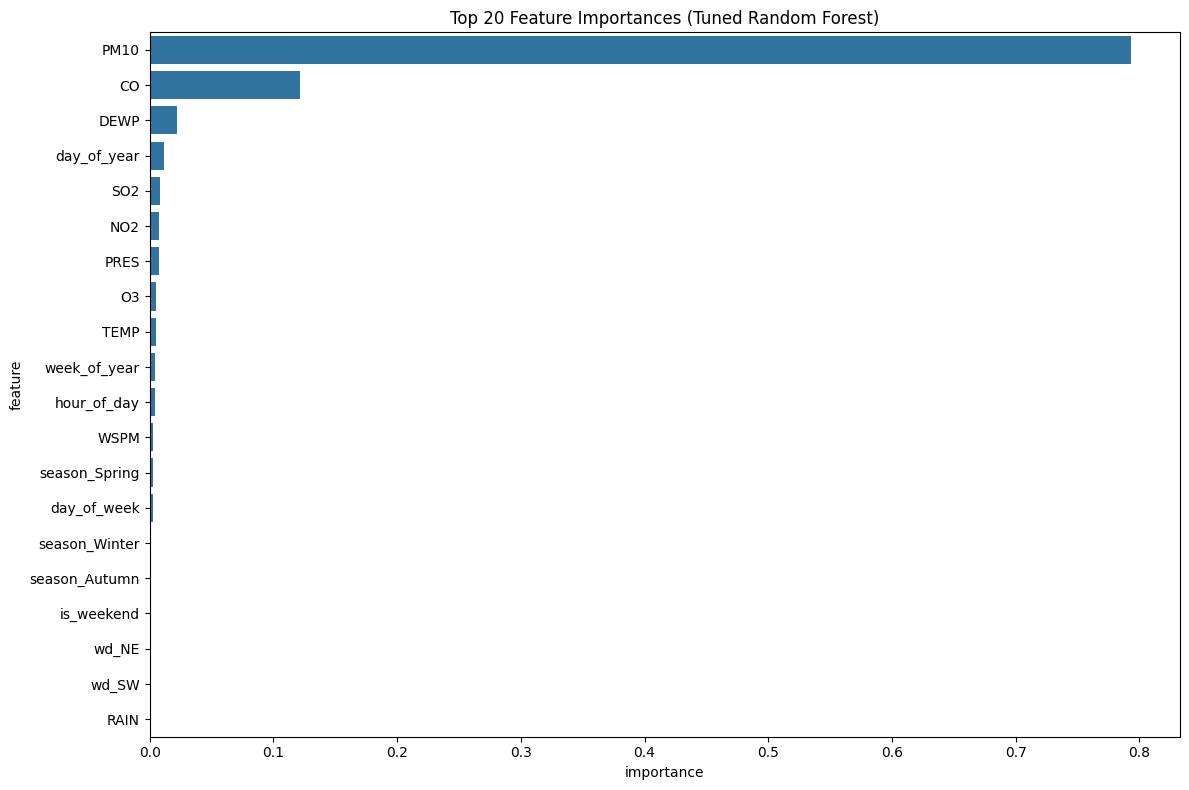

         feature  importance
0           PM10    0.793171
3             CO    0.121343
7           DEWP    0.022243
12   day_of_year    0.011204
1            SO2    0.008248
2            NO2    0.007471
6           PRES    0.007322
4             O3    0.005308
5           TEMP    0.004783
13  week_of_year    0.004550

--- Task 3 Script Finished ---


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Task 1 & 2: Condensed Data Loading and Preprocessing ---
file_path = 'PRSA_Data_Aotizhongxin_20130301-20170228.csv' # Or the full path

try:
    df = pd.read_csv(file_path)
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], errors='coerce')
    df.set_index('datetime', inplace=True)
    columns_to_drop = ['No', 'station'] # Keep year, month, day, hour for now for easy splitting
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # 1. Handle Missing Values (simplified for brevity, using interpolation for all numerics)
    numerical_cols = df.select_dtypes(include=np.number).columns
    for col in numerical_cols:
        df[col] = df[col].interpolate(method='linear', limit_direction='both')
    if 'wd' in df.columns: # Wind direction
        df['wd'] = df['wd'].fillna(method='ffill').fillna(method='bfill')
    df.dropna(inplace=True) # Drop any remaining NaNs

    # 2. Create Time-Based Features
    df['hour_of_day'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    # df['month'] is already present
    # df['year'] is already present
    df['week_of_year'] = df.index.isocalendar().week.astype(int)
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    def get_season(date):
        month_val = date.month
        if month_val in [12, 1, 2]: return 'Winter'
        elif month_val in [3, 4, 5]: return 'Spring'
        elif month_val in [6, 7, 8]: return 'Summer'
        else: return 'Autumn'
    df['season'] = df.index.to_series().apply(get_season)

    # 3. Handle Categorical Features
    df = pd.get_dummies(df, columns=['wd', 'season'], dummy_na=False)

    # Drop original year, month, day, hour after use for splitting and feature engineering
    df.drop(columns=['year', 'month', 'day', 'hour'], inplace=True, errors='ignore')


    print("--- Data Loaded and Preprocessed ---")
    print(f"Shape of processed DataFrame: {df.shape}")
    print(df.head())
    print("\n")
    if df.isnull().sum().any():
        print("Warning: NaNs still present after preprocessing!")
        print(df.isnull().sum())
    else:
        print("No NaNs in the preprocessed DataFrame.")


    # --- Task 3: Regression Model Development and Evaluation ---

    # 1. Define Features (X) and Target (y)
    if 'PM2.5' not in df.columns:
        raise ValueError("Target column 'PM2.5' not found in DataFrame.")

    y = df['PM2.5']
    X = df.drop(columns=['PM2.5'])

    # Ensure all columns in X are numeric
    X = X.apply(pd.to_numeric, errors='coerce') # Coerce non-numeric to NaN
    if X.isnull().sum().any():
        print("Warning: NaNs introduced in X after converting to numeric. Imputing with mean.")
        X = X.fillna(X.mean()) # Simple imputation for any coerced NaNs
        if X.isnull().sum().any(): # If mean is NaN (e.g. all NaNs in a column)
             X = X.fillna(0) # Fallback to 0

    # 2. Split Data Chronologically (Train, Validation, Test)
    # Example split: Train up to end of 2015, Validate 2016 Jan-Aug, Test 2016 Sep - 2017 Feb

    # Ensure index is sorted for chronological split
    df_original_index_for_split = df.index.sort_values()

    train_end_date = pd.Timestamp('2015-12-31 23:59:59')
    validation_end_date = pd.Timestamp('2016-08-31 23:59:59')

    X_train = X[X.index <= train_end_date]
    y_train = y[y.index <= train_end_date]

    X_val = X[(X.index > train_end_date) & (X.index <= validation_end_date)]
    y_val = y[(y.index > train_end_date) & (y.index <= validation_end_date)]

    X_test = X[X.index > validation_end_date]
    y_test = y[y.index > validation_end_date]

    if X_train.empty or X_val.empty or X_test.empty:
        raise ValueError("One or more data splits are empty. Check split dates and data range.")

    print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
    print(f"Validation set shape: X_val={X_val.shape}, y_val={y_val.shape}")
    print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}\n")

    # 3. Scale Numerical Features
    # Identify numerical features to scale (all columns in X are now numeric)
    numerical_features_to_scale = X_train.columns.tolist()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Convert scaled arrays back to DataFrames for easier handling (optional, but good for consistency)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    print("--- Feature Scaling Applied ---")
    print("X_train_scaled head:")
    print(X_train_scaled.head())
    print("\n")

    # --- Helper function for model evaluation ---
    def evaluate_model(name, y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        print(f"--- {name} Model Evaluation ---")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse):.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R-squared (R²): {r2:.4f}\n")
        return mse, mae, r2

    # --- Helper function for plotting predictions ---
    def plot_predictions(name, y_true, y_pred):
        plt.figure(figsize=(15, 6))
        plt.plot(y_true.index, y_true, label='Actual PM2.5', alpha=0.7)
        plt.plot(y_true.index, y_pred, label=f'Predicted PM2.5 ({name})', alpha=0.7, linestyle='--')
        plt.title(f'Actual vs. Predicted PM2.5 ({name}) on Test Set')
        plt.xlabel('Date')
        plt.ylabel('PM2.5 Concentration (µg/m³)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # --- Model 1: Linear Regression ---
    print("--- Training Linear Regression Model ---")
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred_lr_val = lr_model.predict(X_val_scaled)
    y_pred_lr_test = lr_model.predict(X_test_scaled)

    # Evaluation
    print("Validation Set Evaluation (Linear Regression):")
    evaluate_model("Linear Regression (Validation)", y_val, y_pred_lr_val)
    print("Test Set Evaluation (Linear Regression):")
    evaluate_model("Linear Regression (Test)", y_test, y_pred_lr_test)
    plot_predictions("Linear Regression", y_test, y_pred_lr_test)


    # --- Model 2: Random Forest Regressor ---
    print("\n--- Training Random Forest Regressor Model (Initial) ---")
    rf_model_initial = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=10, min_samples_leaf=5)
    rf_model_initial.fit(X_train_scaled, y_train)

    # Predictions (Initial Model)
    y_pred_rf_initial_val = rf_model_initial.predict(X_val_scaled)
    y_pred_rf_initial_test = rf_model_initial.predict(X_test_scaled)

    print("Validation Set Evaluation (Random Forest - Initial):")
    evaluate_model("Random Forest Initial (Validation)", y_val, y_pred_rf_initial_val)
    print("Test Set Evaluation (Random Forest - Initial):")
    evaluate_model("Random Forest Initial (Test)", y_test, y_pred_rf_initial_test)
    # plot_predictions("Random Forest Initial", y_test, y_pred_rf_initial_test) # Plot later after tuning

    # Hyperparameter Tuning for Random Forest using GridSearchCV
    print("\n--- Hyperparameter Tuning for Random Forest ---")
    # Define a smaller parameter grid for faster tuning demonstration
    param_grid_rf = {
        'n_estimators': [50, 100], # Reduced from [100, 200]
        'max_depth': [10, 20, None], # Reduced options
        'min_samples_split': [5, 10], # Reduced from [2, 5, 10]
        'min_samples_leaf': [3, 5]    # Reduced from [1, 2, 4]
    }

    # TimeSeriesSplit for cross-validation in time series context
    # n_splits can be adjusted. Using 3 for demonstration.
    tscv = TimeSeriesSplit(n_splits=3)

    rf_model_for_tuning = RandomForestRegressor(random_state=42, n_jobs=-1)



    grid_search_rf = GridSearchCV(estimator=rf_model_for_tuning, param_grid=param_grid_rf,
                                  cv=tscv, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

    print("Starting GridSearchCV for Random Forest... (This may take some time)")
    grid_search_rf.fit(X_train_scaled, y_train) # Tune on the training set

    best_rf_model = grid_search_rf.best_estimator_
    print(f"\nBest Random Forest Parameters: {grid_search_rf.best_params_}")

    # Predictions with Tuned Model
    y_pred_rf_tuned_val = best_rf_model.predict(X_val_scaled)
    y_pred_rf_tuned_test = best_rf_model.predict(X_test_scaled)

    # Evaluation of Tuned Model
    print("\nValidation Set Evaluation (Random Forest - Tuned):")
    evaluate_model("Random Forest Tuned (Validation)", y_val, y_pred_rf_tuned_val)
    print("Test Set Evaluation (Random Forest - Tuned):")
    evaluate_model("Random Forest Tuned (Test)", y_test, y_pred_rf_tuned_test)
    plot_predictions("Random Forest Tuned", y_test, y_pred_rf_tuned_test)

    # Feature Importance for Tuned Random Forest
    print("\n--- Feature Importances (Tuned Random Forest) ---")
    importances = best_rf_model.feature_importances_
    feature_names = X_train.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20)) # Top 20 features
    plt.title('Top 20 Feature Importances (Tuned Random Forest)')
    plt.tight_layout()
    plt.show()
    print(feature_importance_df.head(10))




except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please ensure the file path is correct and the CSV file is in the specified location.")
except ValueError as ve:
    print(f"ValueError: {ve}")
    print("Please check data splits, column names, or data integrity.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()
    print("Please check your data and script carefully.")

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
}
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1),
                           param_grid, cv=tscv, scoring='neg_mean_absolute_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_rf_model = grid_search.best_estimator_


Fitting 5 folds for each of 24 candidates, totalling 120 fits
